## **Assignment 2**
Parsa Youssefpour



In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
!pip install pyvirtualdisplay

In [ ]:
!sudo apt-get install xvfb

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iterations that were run: 11


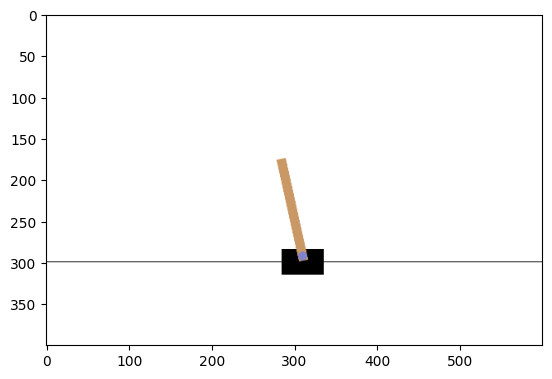

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

Exercises
1. Explain clearly why V_pi is not useful in the MC development above?

Answer:
V_pi is not useful in the MC development because the MC methods aims to estimate the optimal state action value function (Q). In addition the policy is determined based on the action that has the the highest value in a particular state in the Q function, which is value that V_pi does not provide.

---

2. The MC algorithm so far (ref: p 99), requires an infinite number of episodes for Eval to converge on Q_pi_k (step k). We can modify this algorithm to the practical variant where Eval is truncated (c.f., DynProg GPI). In this case:

      a. Will we obtain Q_pi_k from eval?

      Answer:
      No, the evaluation process requires an infinite number of episodes, as it needs to cover are possible state action combinations and their combination with other state actions. This process could potentially take multiple years to finish which makes this impossible.

      ---

      b. If not why are we able to truncate Eval? Explain clearly.

      Answer:
      with truncate Eval we have a significantly more efficient method to get a very close estimate of Q_pi_k, without having to generate an infinite number of episodes. In this method after every episode generated based on our policy, the polciy is evaluated and improved. Through these itereation we will be able to get a policy and a Q function that is close enough to their optimal values.

      ---

      c. Assuming ES (i.e., thorough sampling of the S x A space), and the above truncated Eval_trunc, is it possible to converge on a sub-optimal policy pi_c? Is this a stable fixed point of the GPI for MC? Explain clearly.

      Answer:
      The use of exploratory start guarantees that we will get to the global optimum of all policies. This means that even with the eval_trunc we are able to evaluate and improve the policy as we explore through all possible state action combinations. This allows us to ensure that we reach the optimal policy as all state action pair have been experienced, hence it allows us to reach a stable point of the GPI for MC.

      ---


3. Explain how you can synthesize a stochastic policy given what you know so far (you don't need to read ahead).

Answer:
A stochastic policy can be made by first using a policy that has a >0 probability of all actions occuring. Next, the policy values for each state action can be updated with respect to their Q function value. The policy's probability for the action with the highest value is set to

1-epsilon + epsilon/#actions

and all the other action's probability values are set to

epsilon/#actions


---

Exercise:

Code the algorithm for MC Control (Off Policy) and apply this to the Cart Pole problem. You must discretize the environmental feedback (S) in order to solve this problem properly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
import numpy as np
import random
import csv

In [ ]:
# initializing Q function, C function, Behaviour policy and Target policy
Q={}
C={}
b ={}
policy = {}

#turning the multidimensional observation into a tuple to use it as a key for q dict
def create_state(observation):
  #rounding the 4 values in the observation, to reduce the number of states
  formatted_list = [ '%.1f' % elem for elem in observation ]
  return tuple(formatted_list)

def b_policy(state):
  #initiating a new state with random values
  #for behaviour policy, Q function, C function
  #and the target policy
  if state not in Q.keys():
    b[state] = [0.5,0.5]
    Q[state] = [0,0]
    C[state] = [0,0]
    policy[state] = [0,0]

  return b[state]


#updating q
def update_q(episode , gamma):

  # creating a list of rewards per state action pairs
  rewards = [reward for (state, action, reward) in episode]

  #initialising G and W
  G = 0
  W = 1

  #looping through the state action pairs in the episode to update the q
  for t in range(len(episode)-2,-1,-1):
    (state, action, reward) = episode[t]
    G = gamma * G + rewards[t+1]

    C[state][action] += W
    Q[state][action] += (W/C[state][action])*(G-Q[state][action])

    # updating target policy
    best_action = np.argmax(Q[state])
    for i in range(len(Q[state])):
      if i == best_action:
        policy[state][i] = 1
      else:
        policy[state][i] = 0

    if action != best_action:
      return True

    W = W*(1/b[state][action])

#generating an episode based on the behaviour policy
def generate_episode(obs):
  episode = []
  done = False
  while not done:
    #creating a state as the dictionary key
    state = create_state(obs)
    b_probs = b_policy(state)
    action = np.random.choice(np.arange(len(b_probs)), p=b_probs)
    obs, reward, done, info = env.step(action)
    state = create_state(obs)
    episode.append((state, action, reward))

  return episode


def MC(gamma, epoch):

  for i in range(epoch):
    obs = env.reset()
    #generating and episode
    episode = generate_episode(obs)
    #updating the q values based on the generated episode
    update_q(episode, gamma = gamma)

    if i % 100_000 == 0:
      print(f"Episode {i}")

      #saving the action value function
      with open('/content/drive/MyDrive/Q.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i])
        for state, action in Q.items():
          writer.writerow([state,action[0],action[1]])

  return policy

In [ ]:
env = gym.make("CartPole-v0",max_episode_steps=10_000)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
#calling the monte carlo function
q = MC(gamma = 0.99, epoch =10_000_000)

Episode 0
Episode 100000
Episode 200000
Episode 300000
Episode 400000
Episode 500000
Episode 600000
Episode 700000
Episode 800000
Episode 900000
Episode 1000000
Episode 1100000
Episode 1200000
Episode 1300000
Episode 1400000
Episode 1500000
Episode 1600000
Episode 1700000
Episode 1800000
Episode 1900000
Episode 2000000
Episode 2100000
Episode 2200000
Episode 2300000
Episode 2400000
Episode 2500000
Episode 2600000
Episode 2700000
Episode 2800000
Episode 2900000
Episode 3000000
Episode 3100000
Episode 3200000
Episode 3300000
Episode 3400000
Episode 3500000
Episode 3600000
Episode 3700000
Episode 3800000
Episode 3900000
Episode 4000000
Episode 4100000
Episode 4200000
Episode 4300000
Episode 4400000
Episode 4500000
Episode 4600000
Episode 4700000
Episode 4800000
Episode 4900000
Episode 5000000
Episode 5100000
Episode 5200000
Episode 5300000
Episode 5400000
Episode 5500000
Episode 5600000
Episode 5700000
Episode 5800000
Episode 5900000
Episode 6000000
Episode 6100000
Episode 6200000
Episode

42 0
Iterations that were run: 41


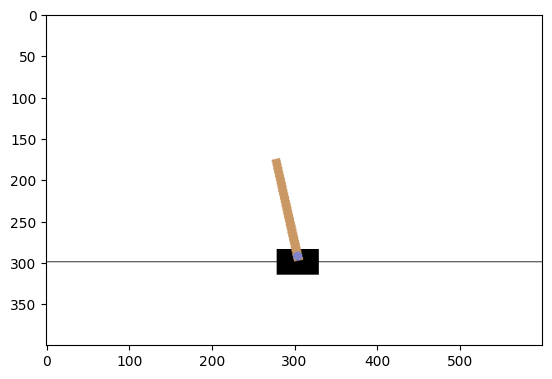

In [ ]:
#TESTING
env = gym.make("CartPole-v0", max_episode_steps=10000)
obs = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
n_policy =0
n_random = 0
for i in range(50000):
  state = create_state(obs)
  print(state)
  try:
    action = np.argmax(Q[state])
    print(action)
    print("POLICY")
    n_policy+=1

  #if somehow the state has not been visited in the training, generate a random move
  except:
    print("random")
    action = env.action_space.sample()
    n_random+=1
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print(n_policy,n_random)
print("Iterations that were run:",i)

Analysis:
Off Policy Monte Carlo is significantly slower and less efficient compared to On policy monte carlo.